## Direction

## Target=お弁当の売り上げ数を予測(回帰問題)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font="IPAexGothic",style="white")

Duplicate key in file PosixPath('/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family : IPAexGothic')


## 基礎分析

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv",header=None)
print("Data Shapes")
print("Train:",train.shape, "Test:",test.shape, "Sample:",sample.shape)

Data Shapes
Train: (207, 12) Test: (40, 11) Sample: (40, 2)


In [3]:
train.index = pd.to_datetime(train["datetime"])
train.head()

datetime    y week  soldout        name  kcal remarks event  \
datetime                                                                    
2013-11-18  2013-11-18   90    月        0    厚切りイカフライ   NaN     NaN   NaN   
2013-11-19  2013-11-19  101    火        1     手作りヒレカツ   NaN     NaN   NaN   
2013-11-20  2013-11-20  118    水        0  白身魚唐揚げ野菜あん   NaN     NaN   NaN   
2013-11-21  2013-11-21  120    木        1      若鶏ピリ辛焼   NaN     NaN   NaN   
2013-11-22  2013-11-22  130    金        1    ビッグメンチカツ   NaN     NaN   NaN   

            payday weather precipitation  temperature  
datetime                                               
2013-11-18     NaN      快晴            --         19.8  
2013-11-19     NaN      快晴            --         17.0  
2013-11-20     NaN      快晴            --         15.5  
2013-11-21     NaN      快晴            --         15.2  
2013-11-22     NaN      快晴            --         16.1

In [4]:
train.describe()

y     soldout        kcal  payday  temperature
count  207.000000  207.000000  166.000000    10.0   207.000000
mean    86.623188    0.449275  404.409639     1.0    19.252174
std     32.882448    0.498626   29.884641     0.0     8.611365
min     29.000000    0.000000  315.000000     1.0     1.200000
25%     57.000000    0.000000  386.000000     1.0    11.550000
50%     78.000000    0.000000  408.500000     1.0    19.800000
75%    113.000000    1.000000  426.000000     1.0    26.100000
max    171.000000    1.000000  462.000000     1.0    34.600000

In [5]:
train.describe(include="O")  #include object

datetime week      name   remarks event weather precipitation
count        207  207       207        21    14     207           207
unique       207    5       156         6     2       7             8
top     2014-8-6    木  タンドリーチキン  お楽しみメニュー  ママの会       曇            --
freq           1   43         6        12     9      53           169

## 欠損値補間と月情報の特徴量の作成

In [6]:
train["payday"] = train["payday"].fillna(0)
train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x == "--" else float(x))
train["event"] = train["event"].fillna("なし")
train["remarks"] = train["remarks"].fillna("なし")
train["month"] = train["datetime"].apply(lambda x : int(x.split("-")[1]))

In [7]:
train["precipitation"].value_counts()

-1.0    169
 0.0     23
 0.5      9
 1.5      2
 2.5      1
 1.0      1
 6.5      1
 6.0      1
Name: precipitation, dtype: int64

## お弁当の売り上げ分布の確認

<AxesSubplot:xlabel='datetime'>

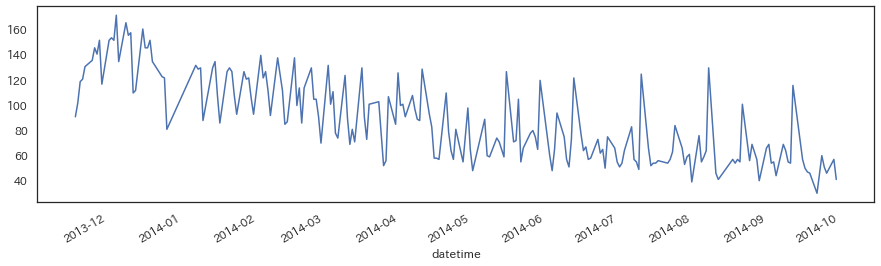

In [8]:
train["y"].plot(figsize=(15,4))

- 経時変化あり
- スパイクあり

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

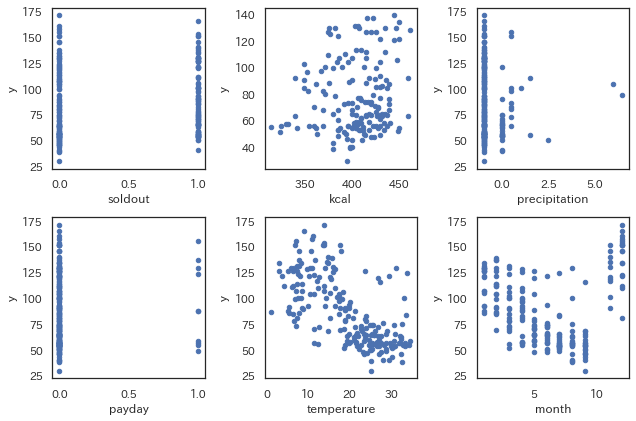

In [9]:
fig, ax = plt.subplots(2,3,figsize=(9,6))                         #2行3列
train.plot.scatter(x="soldout", y="y", ax=ax[0][0])
train.plot.scatter(x="kcal", y="y", ax=ax[0][1])
train.plot.scatter(x="precipitation", y="y", ax=ax[0][2])
train.plot.scatter(x="payday", y="y", ax=ax[1][0])
train.plot.scatter(x="temperature", y="y", ax=ax[1][1])
train.plot.scatter(x="month", y="y", ax=ax[1][2])
plt.tight_layout()

temperatureとmonthが相関ありそう
（ただし時間依存あるので代替変数の可能性高い）

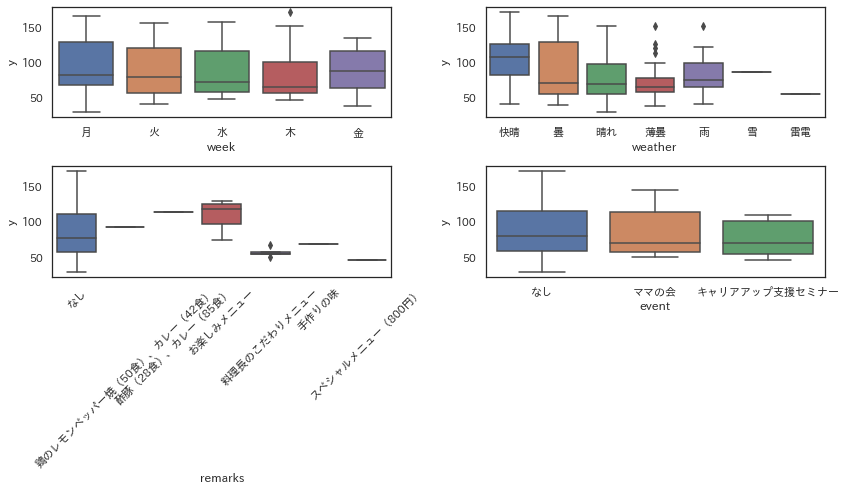

In [10]:
fig, ax = plt.subplots(2,2,figsize=(12,7))
sns.boxplot(x="week",y="y",data=train,ax=ax[0][0])
sns.boxplot(x="weather",y="y",data=train,ax=ax[0][1])
sns.boxplot(x="remarks",y="y",data=train,ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(),rotation=45)
sns.boxplot(x="event",y="y",data=train,ax=ax[1][1])
plt.tight_layout()

お楽しみメニュー有り無しが影響ありそう

お楽しみメニューあり

<AxesSubplot:xlabel='datetime'>

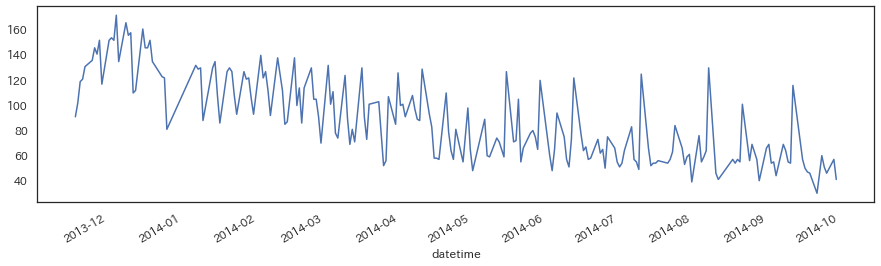

In [11]:
train["y"].plot(figsize=(15,4))

お楽しみメニューなし

<AxesSubplot:xlabel='datetime'>

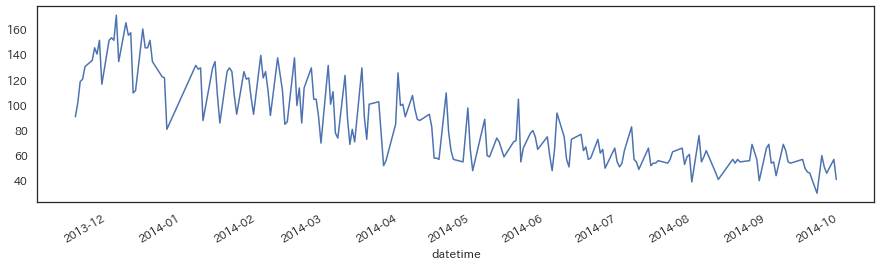

In [12]:
train[train["remarks"]!="お楽しみメニュー"]["y"].plot(figsize=(15,4))

お楽しみメニューを除いても、まだスパイクあり

<AxesSubplot:xlabel='fun', ylabel='y'>

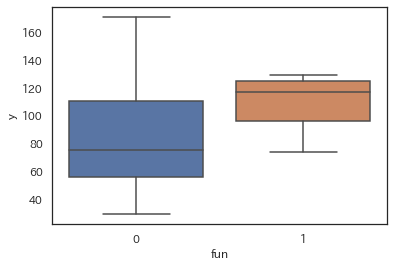

In [13]:
train["fun"] = train["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
sns.boxplot(x="fun",y="y",data=train)

## 中央値検定(メディアン検定)

2標本それぞれについてmより大きい（もしくはm以上の）データの件数とm以下（もしくはm未満）のデータの件数を求め、2行×2列の分割表を作成する。この分割表に対してカイ二乗検定を行い、2標本の分布が独立かどうかを検定する。

In [14]:
from scipy.stats import median_test
stat,p,med,tbl = median_test(train[train["fun"]==1]["y"],train[train["fun"]==0]["y"])
print("p",p,"stat",stat)

p 0.007057960766247775 stat 7.2581589841730345


p値が0.05以下なので有意差あり

↓お楽しみメニューだけでも差はあり

<AxesSubplot:xlabel='datetime'>

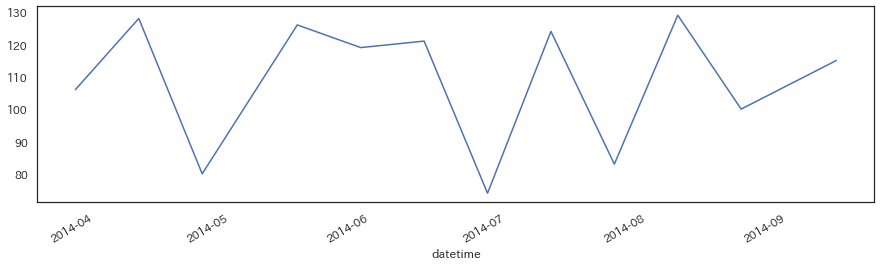

In [15]:
train[train["remarks"]=="お楽しみメニュー"]["y"].plot(figsize=(15,4))

In [16]:
train[train["remarks"]=="お楽しみメニュー"]

datetime    y week  soldout              name  kcal   remarks  \
datetime                                                                     
2014-03-28  2014-3-28  106    金        0            キーマカレー   NaN  お楽しみメニュー   
2014-04-11  2014-4-11  128    金        1            チキンカレー   NaN  お楽しみメニュー   
2014-04-25  2014-4-25   80    金        0               中華丼   NaN  お楽しみメニュー   
2014-05-16  2014-5-16  126    金        0            ポークカレー   NaN  お楽しみメニュー   
2014-05-30  2014-5-30  119    金        0            チキンカレー   NaN  お楽しみメニュー   
2014-06-13  2014-6-13  121    金        0            キーマカレー   NaN  お楽しみメニュー   
2014-06-27  2014-6-27   74    金        0                牛丼   NaN  お楽しみメニュー   
2014-07-11  2014-7-11  124    金        0            ポークカレー   NaN  お楽しみメニュー   
2014-07-25  2014-7-25   83    金        0  ひやしたぬきうどん・炊き込みご飯   NaN  お楽しみメニュー   
2014-08-08   2014-8-8  129    金        0            チキンカレー   NaN  お楽しみメニュー   
2014-08-22  2014-8-22  100    金        1             ロコモコ丼   NaN  お楽しみメニュー   
2014-09-12  2014-9-12  115    金        0            ポークカレー   NaN  お楽しみメニュー   

           event  payday weather  precipitation  temperature  month  fun  
datetime                                                                  
2014-03-28    なし     0.0      快晴           -1.0         18.5      3    1  
2014-04-11    なし     0.0      快晴           -1.0         16.5      4    1  
2014-04-25    なし     0.0      晴れ           -1.0         20.8      4    1  
2014-05-16  ママの会     0.0      快晴           -1.0         23.8      5    1  
2014-05-30    なし     0.0      薄曇           -1.0         26.9      5    1  
2014-06-13    なし     0.0      晴れ           -1.0         29.5      6    1  
2014-06-27    なし     0.0       雨            0.0         25.4      6    1  
2014-07-11    なし     0.0      晴れ           -1.0         33.9      7    1  
2014-07-25    なし     0.0      晴れ           -1.0         33.6      7    1  
2014-08-08    なし     1.0       曇           -1.0         31.1      8    1  
2014-08-22    なし     0.0      晴れ           -1.0         33.1      8    1  
2014-09-12    なし     0.0      晴れ           -1.0         27.3      9    1

カレーの時が高そう

<AxesSubplot:xlabel='curry', ylabel='y'>

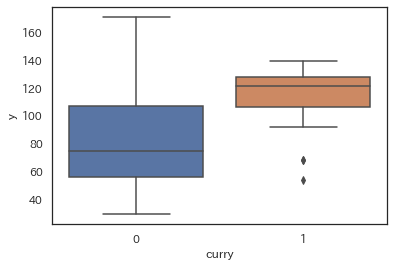

In [17]:
train["curry"] = train["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
sns.boxplot(x="curry",y="y",data=train)

In [18]:
stat,p,med,tbl = median_test(train[train["curry"]==1]["y"],train[train["curry"]==0]["y"])
print("p:",p,"stat",stat)

p: 0.010699742900892427 stat 6.514516162828877


## Method

以下はオリジナル
1. トレンドが異なる2014-05-01以前のデータ削除
2. 説明変数は"precipitation","weather","days","fun","curry"
3. "weather_雷電"はtestデータになかったので削除 　→結果的にRMSEは上昇
4. 単回帰とRandomForrestモデルを組み合わせ

In [138]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv",header=None)

In [20]:
train.index = pd.to_datetime(train["datetime"])
train = train["2014-05-01":]
train = train.reset_index(drop=True)

In [21]:
train.head()

datetime   y week  soldout      name   kcal remarks event  payday weather  \
0  2014-5-1  64    木        0     マーボ茄子  415.0     NaN   NaN     NaN      晴れ   
1  2014-5-2  47    金        0     鶏の天ぷら  420.0     NaN   NaN     NaN      晴れ   
2  2014-5-7  88    水        1      肉じゃが  415.0     NaN   NaN     NaN      晴れ   
3  2014-5-8  59    木        0     メンチカツ  405.0     NaN   NaN     NaN      薄曇   
4  2014-5-9  58    金        1  手作りチキンカツ  434.0     NaN   NaN     1.0      晴れ   

  precipitation  temperature  
0            --         24.0  
1            --         23.3  
2            --         18.9  
3            --         21.0  
4            --         23.4

In [22]:
train["days"] = train.index
train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)
train["fun"] = train["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
train["curry"] = train["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)

cols = ["precipitation","weather","days","fun","curry","y"]

<ipython-input-22-461e686da040>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)


In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF

In [24]:
def learning(trainX,y_train):
    model1 = LR()
    model2 = RF(n_estimators=100,max_depth=4,random_state=None)
    model1.fit(trainX["days"].values.reshape(-1,1),y_train)
    pred = model1.predict(trainX["days"].values.reshape(-1,1))
    
    pred_sub = y_train - pred
    model2.fit(trainX,pred_sub)
    return model1, model2

In [25]:
train.head()

datetime   y week  soldout      name   kcal remarks event  payday weather  \
0  2014-5-1  64    木        0     マーボ茄子  415.0     NaN   NaN     NaN      晴れ   
1  2014-5-2  47    金        0     鶏の天ぷら  420.0     NaN   NaN     NaN      晴れ   
2  2014-5-7  88    水        1      肉じゃが  415.0     NaN   NaN     NaN      晴れ   
3  2014-5-8  59    木        0     メンチカツ  405.0     NaN   NaN     NaN      薄曇   
4  2014-5-9  58    金        1  手作りチキンカツ  434.0     NaN   NaN     1.0      晴れ   

   precipitation  temperature  days  fun  curry  
0           -1.0         24.0     0    0      0  
1           -1.0         23.3     1    0      0  
2           -1.0         18.9     2    0      0  
3           -1.0         21.0     3    0      0  
4           -1.0         23.4     4    0      0

In [26]:
trainX = pd.get_dummies(train[["precipitation","weather","days","fun","curry"]])
y_train = train["y"]
trainX.head()

precipitation  days  fun  curry  weather_快晴  weather_晴れ  weather_曇  \
0           -1.0     0    0      0           0           1          0   
1           -1.0     1    0      0           0           1          0   
2           -1.0     2    0      0           0           1          0   
3           -1.0     3    0      0           0           0          0   
4           -1.0     4    0      0           0           1          0   

   weather_薄曇  weather_雨  weather_雷電  
0           0          0           0  
1           0          0           0  
2           0          0           0  
3           1          0           0  
4           0          0           0

In [27]:
trainX = trainX.drop("weather_雷電",axis=1)

In [28]:
model1, model2 = learning(trainX, y_train)

In [29]:
pred_train = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX)

In [30]:
from sklearn.metrics import mean_squared_error as MSE
print("RMSE",MSE(y_train, pred_train)**0.5)

RMSE 8.0595647944256


RMSE 8.0595647944256


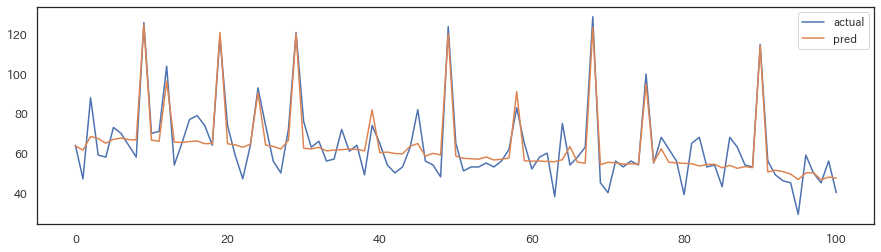

In [31]:
p = pd.DataFrame({"actual":y_train,"pred":pred_train})
p.plot(figsize=(15,4))
print("RMSE",MSE(y_train,pred_train)**0.5)

In [32]:
test["days"] = test.index
test["precipitation"] = test["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)
test["fun"] = test["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
test["curry"] = test["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)

<ipython-input-32-e942b6a17e54>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test["precipitation"] = test["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)


In [33]:
testX = pd.get_dummies(test[["precipitation","weather","days","fun","curry"]])

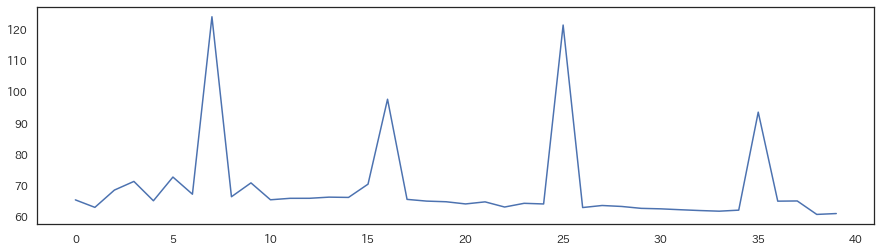

In [34]:
#model1, model2 = learning(trainX,y_train)
pred_test = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX)
#pred = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:,~testX.columns.str.match("y")])
plt.figure(figsize=(15,4))
plt.plot(pred_test)

In [35]:
trainX.head()

precipitation  days  fun  curry  weather_快晴  weather_晴れ  weather_曇  \
0           -1.0     0    0      0           0           1          0   
1           -1.0     1    0      0           0           1          0   
2           -1.0     2    0      0           0           1          0   
3           -1.0     3    0      0           0           0          0   
4           -1.0     4    0      0           0           1          0   

   weather_薄曇  weather_雨  
0           0          0  
1           0          0  
2           0          0  
3           1          0  
4           0          0

In [36]:
testX.head()

precipitation  days  fun  curry  weather_快晴  weather_晴れ  weather_曇  \
0            0.0     0    0      0           0           0          0   
1           -1.0     1    0      0           0           0          1   
2           -1.0     2    0      0           0           1          0   
3            0.5     3    0      0           0           0          0   
4           -1.0     4    0      0           0           1          0   

   weather_薄曇  weather_雨  
0           0          1  
1           0          0  
2           0          0  
3           0          1  
4           0          0

## trainとtestの同時前処理

In [145]:
train["t"] = 1
test["t"] = 0
dat = pd.concat([train,test])      #Concatenate 鎖状につなぐ

In [146]:
dat

datetime      y week  soldout          name   kcal   remarks event  \
0   2013-11-18   90.0    月        0      厚切りイカフライ    NaN       NaN   NaN   
1   2013-11-19  101.0    火        1       手作りヒレカツ    NaN       NaN   NaN   
2   2013-11-20  118.0    水        0    白身魚唐揚げ野菜あん    NaN       NaN   NaN   
3   2013-11-21  120.0    木        1        若鶏ピリ辛焼    NaN       NaN   NaN   
4   2013-11-22  130.0    金        1      ビッグメンチカツ    NaN       NaN   NaN   
..         ...    ...  ...      ...           ...    ...       ...   ...   
35  2014-11-21    NaN    金        0         ロコモコ丼    NaN  お楽しみメニュー   NaN   
36  2014-11-25    NaN    火        1   なすと挽肉のはさみ揚げ  460.0       NaN   NaN   
37  2014-11-26    NaN    水        1       鶏肉の治部煮風  415.0       NaN   NaN   
38  2014-11-27    NaN    木        0           牛丼風  420.0       NaN   NaN   
39  2014-11-28    NaN    金        0  鶏肉のスイートチリソース  416.0       NaN   NaN   

    payday weather precipitation  temperature  t  
0      NaN      快晴            --         19.8  1  
1      NaN      快晴            --         17.0  1  
2      NaN      快晴            --         15.5  1  
3      NaN      快晴            --         15.2  1  
4      NaN      快晴            --         16.1  1  
..     ...     ...           ...          ... ..  
35     NaN      快晴            --         14.9  0  
36     NaN       雨           1.5         11.4  0  
37     NaN       雨             1          9.2  0  
38     NaN      快晴            --         15.1  0  
39     NaN       曇            --         15.3  0  

[247 rows x 13 columns]

In [147]:
dat.index = pd.to_datetime(dat["datetime"])
dat = dat["2014-05-01":]
dat = dat.reset_index(drop=True)

In [148]:
dat

datetime     y week  soldout          name   kcal   remarks event  \
0      2014-5-1  64.0    木        0         マーボ茄子  415.0       NaN   NaN   
1      2014-5-2  47.0    金        0         鶏の天ぷら  420.0       NaN   NaN   
2      2014-5-7  88.0    水        1          肉じゃが  415.0       NaN   NaN   
3      2014-5-8  59.0    木        0         メンチカツ  405.0       NaN   NaN   
4      2014-5-9  58.0    金        1      手作りチキンカツ  434.0       NaN   NaN   
..          ...   ...  ...      ...           ...    ...       ...   ...   
136  2014-11-21   NaN    金        0         ロコモコ丼    NaN  お楽しみメニュー   NaN   
137  2014-11-25   NaN    火        1   なすと挽肉のはさみ揚げ  460.0       NaN   NaN   
138  2014-11-26   NaN    水        1       鶏肉の治部煮風  415.0       NaN   NaN   
139  2014-11-27   NaN    木        0           牛丼風  420.0       NaN   NaN   
140  2014-11-28   NaN    金        0  鶏肉のスイートチリソース  416.0       NaN   NaN   

     payday weather precipitation  temperature  t  
0       NaN      晴れ            --         24.0  1  
1       NaN      晴れ            --         23.3  1  
2       NaN      晴れ            --         18.9  1  
3       NaN      薄曇            --         21.0  1  
4       1.0      晴れ            --         23.4  1  
..      ...     ...           ...          ... ..  
136     NaN      快晴            --         14.9  0  
137     NaN       雨           1.5         11.4  0  
138     NaN       雨             1          9.2  0  
139     NaN      快晴            --         15.1  0  
140     NaN       曇            --         15.3  0  

[141 rows x 13 columns]

In [149]:
dat["days"] = dat.index
dat["precipitation"] = dat["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)
dat["fun"] = dat["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
dat["curry"] = dat["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)

cols = ["precipitation","weather","days","fun","curry","y"]

<ipython-input-149-7144442b00ba>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dat["precipitation"] = dat["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)


In [150]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF

In [158]:
def learning(trainX,y_train):
    model1 = LR()
    model2 = RF(n_estimators=100,max_depth=4,random_state=None)
    model1.fit(trainX["days"].values.reshape(-1,1),y_train)
    pred = model1.predict(trainX["days"].values.reshape(-1,1))
    
    pred_sub = y_train - pred
    model2.fit(trainX.iloc[:, ~trainX.columns.str.match("y")],pred_sub)
    return model1, model2

In [161]:
kf = KFold(n_splits=5,random_state=None)
tr = dat[dat["t"]==1][cols]

trains = []
tests = []
for train_index, test_index in kf.split(tr):
    tr.loc[train_index,"tt"] = 1
    tr.loc[test_index,"tt"] = 0
    tr["tt"] = tr["tt"].astype(np.int)
    tmp = pd.get_dummies(tr)
    
    trainX = tmp[tmp["tt"]==1]
    del trainX["tt"]
    testX = tmp[tmp["tt"]==0]
    del testX["tt"]
    y_train = tmp[tmp["tt"]==1]["y"]
    y_test = tmp[tmp["tt"]==0]["y"]
    
    model1, model2 = learning(trainX, y_train)
    
    pred_train = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:, ~trainX.columns.str.match("y")])
    pred_test = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:, ~testX.columns.str.match("y")])
    
    print("TRAIN:",MSE(y_train,pred_train)**0.5, "VARIDATE",MSE(y_test, pred_test)**0.5)
    trains.append(MSE(y_train,pred_train)**0.5)
    tests.append(MSE(y_test, pred_test)**0.5)
print("AVG")
print(np.array(trains).mean(), np.array(tests).mean())

<ipython-input-161-a40c539803fc>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tr["tt"] = tr["tt"].astype(np.int)
<ipython-input-161-a40c539803fc>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for

TRAIN: 7.5203930014190865 VARIDATE 11.377710557268358
TRAIN: 8.046927131093975 VARIDATE 10.533764383701184
TRAIN: 8.307232757998133 VARIDATE 9.16422492865026
TRAIN: 7.961295746916354 VARIDATE 19.57833825551335
TRAIN: 7.955657709484062 VARIDATE 9.483831891353711
AVG
7.958301269382322 12.027574003297373


<ipython-input-161-a40c539803fc>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tr["tt"] = tr["tt"].astype(np.int)
<ipython-input-161-a40c539803fc>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for

In [163]:
cols = ["precipitation","weather","days","fun","curry","y","t"]
tmp = pd.get_dummies(dat[cols])
trainX = tmp[tmp["t"]==1]
del trainX["t"]
testX = tmp[tmp["t"]==0]
del testX["t"]
y_train = tmp[tmp["t"]==1]["y"]
y_test = tmp[tmp["t"]==0]["y"]

RMSE 8.12730205234708


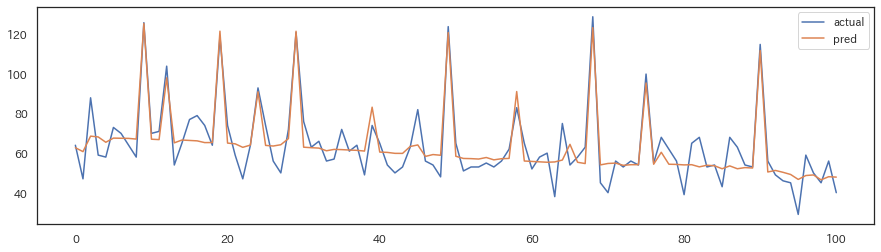

In [164]:
model1, model2 = learning(trainX,y_train)

pred = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:,~trainX.columns.str.match("y")])

p = pd.DataFrame({"actual":y_train,"pred":pred})
p.plot(figsize=(15,4))
print("RMSE",MSE(y_train,pred)**0.5)

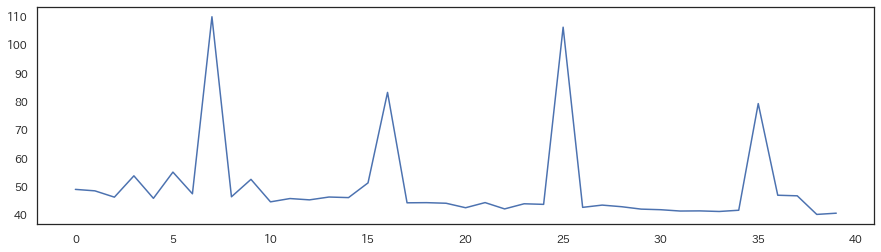

In [165]:
model1, model2 = learning(trainX,y_train)
pred = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:,~testX.columns.str.match("y")])
plt.figure(figsize=(15,4))
plt.plot(pred)